In [1]:
ENV["GKS_ENCODING"] = "utf-8"
include("src/ladderDGA_Julia.jl");

Inputs Read. Starting Computation                                          
Calculating bubble:   3.422461 seconds (11.02 M allocations: 524.248 MiB, 6.36% gc time)
Calculating naiive χ and γ in the charge channel: 15
20
  4.763676 seconds (8.57 M allocations: 637.236 MiB, 8.56% gc time)
Calculating naiive χ and γ in the spin channel: 15
20
  1.551400 seconds (778.40 k allocations: 246.389 MiB, 1.66% gc time)
Calculating λ correction in the charge channel:   4.639298 seconds (12.02 M allocations: 597.229 MiB, 6.76% gc time)
Calculating λ correction in the spin channel:   0.007597 seconds (560 allocations: 1.342 MiB)
Calculating naiive Σ ladder:   0.389840 seconds (470.72 k allocations: 24.057 MiB, 2.42% gc time)
Calculating χ and γ in the charge channel: 15
20
  2.900857 seconds (2.83 M allocations: 436.624 MiB, 4.06% gc time)
Calculating χ and γ in the spin channel: 15
20
  2.036949 seconds (810.01 k allocations: 332.952 MiB, 2.73% gc time)
Calculating Σ ladder:   0.499663 seconds (33

## Test analytical lsq fit

TODO: check for $\nu_n + \omega_n$ shift

In order to minimize $\text{LSQ}(g_n) = \sum_{j=\nu\text{max}_\text{min}}^{\nu\text{max}_\text{max}} \left(f(j) - \left(g_{n}\right)_j\right)^2$
with the tail function for data points $g_j$
\begin{equation}
    f(j) = \sum_{c \in C} \frac{c_{k}}{j^c}
\end{equation}
$k, l$ are a running index for all elements of the set of coefficients $C$ with elements denoted by $c$ and $d$ respectivly.

We first construct 
$M_{kl} = \sum_{j=\nu\text{max}_\text{min}}^{\nu\text{max}_\text{max}} \frac{1}{j^c j^{d}}$
(derivation: minimize least squares sum analytically) and then for the $n$-th set of $j$ datapoints $\left(g_{n}\right)_j$:
\begin{equation}
\left(b_{n}\right)_{l} = \sum_{j=\nu\text{max}_\text{min}}^{\nu\text{max}_\text{max}} \frac{\left(g_{n}\right)_j}{j^d}
\end{equation}

We can then obtain the fit-coefficients $c_n$ of the $n$-th data point by solving $M c_n = b_n$

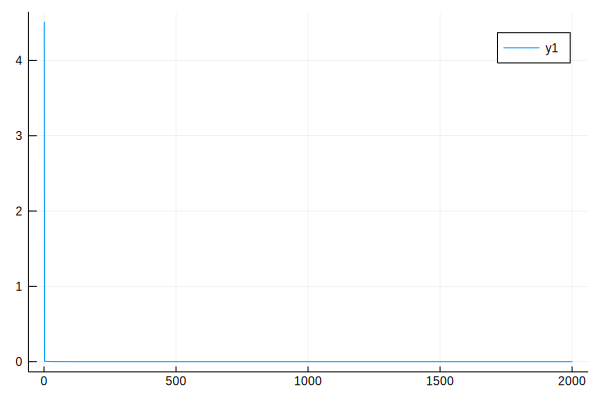

In [2]:
using Plots
chi_asymt = readEDAsymptotics(env)
χEDch = (chi_asymt[:,2] + chi_asymt[:,4]) / (2*modelParams.β*modelParams.β);
χEDsp = (chi_asymt[:,2] - chi_asymt[:,4]) / (2*modelParams.β*modelParams.β);
plot(χEDch)

In [42]:
plot(real(sum(χsp_naive, axis=2)[1]))

MethodError: MethodError: no method matching sum(::Array{Complex{Float64},2}; axis=2)
Closest candidates are:
  sum(::AbstractArray{#s35,N} where N where #s35<:Number, !Matched::StatsBase.AbstractWeights{#s34,T,V} where V<:AbstractArray{T,1} where T<:Real where #s34<:Real, !Matched::Int64) at /home/julian/.julia/packages/StatsBase/DyWPR/src/weights.jl:483 got unsupported keyword argument "axis"
  sum(::AbstractArray; dims) at reducedim.jl:652 got unsupported keyword argument "axis"
  sum(::AbstractArray, !Matched::StatsBase.AbstractWeights) at /home/julian/.julia/packages/StatsBase/DyWPR/src/weights.jl:280 got unsupported keyword argument "axis"
  ...

## Tests for fit of bubble $\omega_n$ sum

In [6]:
include("src/GFFit.jl")
nc = [0,1,2,3]
bubble_sum = sum(bubble, dims=[3])
νmax_end   = floor(Int64,size(bubble,2)/2)
start = ceil(Int64, (2/4)*νmax_end)
W = build_weights(start, νmax_end, nc)
range_red = 0.05
bubble_νsummed = [sum([approx_full_sum(bubble[i,:,j]/modelParams.β, W, modelParams, [1]) for j in 1:size(bubble,3)]) for i in 1:size(bubble,1)]
bubble_naive_νsummed = sum(bubble[:,:,:],dims=[2,3])[:,1,1]/modelParams.β
bubble_νsummed_afterq = [approx_full_sum(bubble_sum[i,:]/modelParams.β, W, modelParams, [1]) for i in 1:size(bubble,1)];
usable_1 = find_usable_interval(bubble_νsummed, reduce_range_prct=range_red)
usable_2 = find_usable_interval(real.(bubble_naive_νsummed), reduce_range_prct=range_red);

Full range of data is 1:239
Usable ranges are 62:177 for naive and 62:177 for fitted with a range reduction of 5.0%


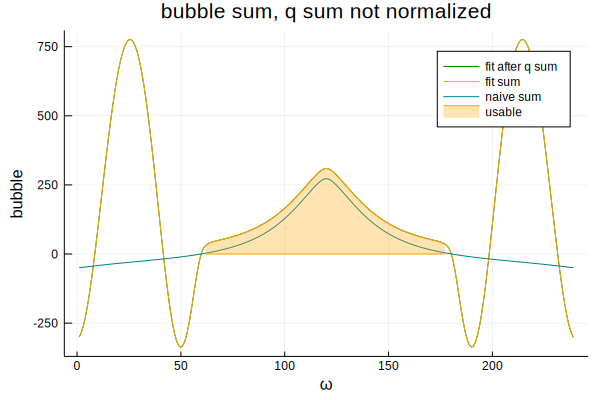

In [7]:
println("Full range of data is $(1:length(bubble_νsummed))\nUsable ranges are $(usable_2) for naive and $(usable_1) for fitted with a range reduction of $(range_red*100)%")
plot(real.(bubble_νsummed_afterq), label="fit after q sum", c=:green, title="bubble sum, q sum not normalized")
plot!(real.(bubble_νsummed), label="fit sum", c=:orange)
plot!(real.(bubble_naive_νsummed),xlabel="ω",ylabel="bubble" ,label="naive sum", c=:teal)
plot!(usable_1, repeat([0], length(usable_1)), fillrange=bubble_νsummed[usable_1], fillalpha=0.3, c=:orange, label="usable")
#plot!(usable_2, repeat([0], length(usable_2)), fillrange=real(bubble_naive_νsummed[usable_2]), fillalpha=0.3, c=:green, label="usable")

## Tests for $\chi (\omega_n)$ sum

In [57]:
include("src/IO.jl")
chi_asymt = readEDAsymptotics(env)
χEDch = (chi_asymt[:,2] + chi_asymt[:,4]) / (2*modelParams.β*modelParams.β);
χEDsp = (chi_asymt[:,2] - chi_asymt[:,4]) / (2*modelParams.β*modelParams.β);
χcharge = χup .+ χdo
χspin = χup .- χdo
# cut off tails and build symmetric function
xrange = 1:1000
χEDsp = χEDsp[xrange]
χEDch = χEDch[xrange]
χEDsp = vcat(reverse(χEDsp[2:end]),χEDsp)
χEDch = vcat(reverse(χEDch[2:end]),χEDch);

χch_lDGA = sum(χch, dims=2)[:,1];
χsp_lDGA = sum(χsp, dims=2)[:,1];

Test convergence against $\frac{1}{4}$ with naiive sum, naiive sum and subtracted $E_\text{kin}$, approximate sum, approximate sum and subtracted $E_\text{kin}$

In [23]:
arr_ED = copy(χEDch + χEDsp)
nc = [0,1,2,3]
ωmax_end   = floor(Int64,size(arr_ED,1)/2)
start = ceil(Int64, (2/4)*ωmax_end)
W = build_weights(start, ωmax_end, nc)
sum_χ_ed = approx_full_sum(arr_ED, W, modelParams, [1])/modelParams.β
println("Naiive sum: $(sum_χ_ed)")

arr_ED = copy(χEDch + χEDsp)
iνₙ, GImp = readGImp(env.inputDir * "/gm_wim")
ϵₖ, Vₖ, μ = read_anderson_parameters(env.inputDir * "/hubb.andpar");
tmp = compute_Ekin(iνₙ, ϵₖ, Vₖ, GImp, modelParams.β; full=true)
Ekin = real(tmp)
println("Ekin = $(Ekin)")
Ekin_error = imag(tmp);
iωₙ2_full  = zeros(length(arr_ED))
for i in 1:length(arr_ED)
    iωₙ2_full[i] = (iω(i - ceil(Int64, length(arr_ED)/2)))^2
end
rem_full = Ekin*(modelParams.β*modelParams.β)/6
ind_0 = argmax(iωₙ2_full)
for n in 1:length(arr_ED)
    if n != ind_0
        arr_ED[n] += 2*Ekin/iωₙ2_full[n]
    end
end
sum_imp_χED = (sum(arr_ED) + rem_full)/(modelParams.β)
println("Sum after subtraction of Ekin term: $(sum_imp_χED)")

nc = [0,1,2,3]
ωmax_end   = floor(Int64,size(arr_ED,1)/2)
start = ceil(Int64, (2/4)*ωmax_end)
W = build_weights(start, ωmax_end, nc)
sum_χ_ed_2 = approx_full_sum(copy(arr_ED), W, modelParams, [1])/modelParams.β  + rem_full/(modelParams.β)
println("Sum after subtraction of Ekin and fit: $(sum_imp_χED)")

Naiive sum: 0.24113011552007224
Ekin = -0.01917907286523022
Sum after subtraction of Ekin term: 0.24089683172513335
Sum after subtraction of Ekin and fit: 0.24089683172513335


### Tests for lDGA case

In [44]:
χch_naive, trilexch_naive  =  calc_χ_trilex(Γch, bubble, modelParams.U, modelParams.β, simParams, approx_full_sum = false);
χsp_naive, trilexsp_naive = calc_χ_trilex(Γsp, bubble, -modelParams.U, modelParams.β, simParams, approx_full_sum = false);

In [58]:
size(χch_lDGA)

(239,)

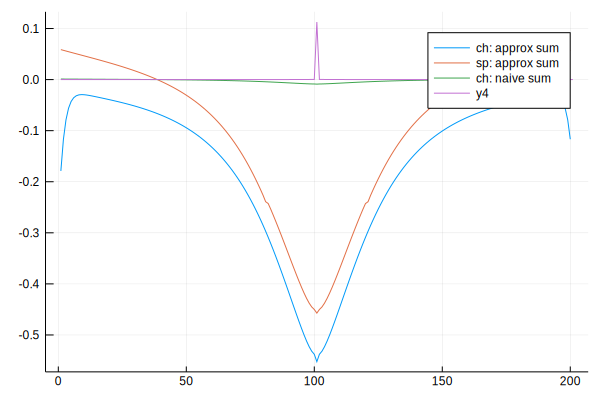

In [59]:
plot(real(χch_lDGA[20:(end-20)]), label="ch: approx sum")
plot!(real(χsp_lDGA[20:(end-20)]), label="sp: approx sum")
plot!(real(χch_naive[20:(end-20),1]), label="ch: naive sum")

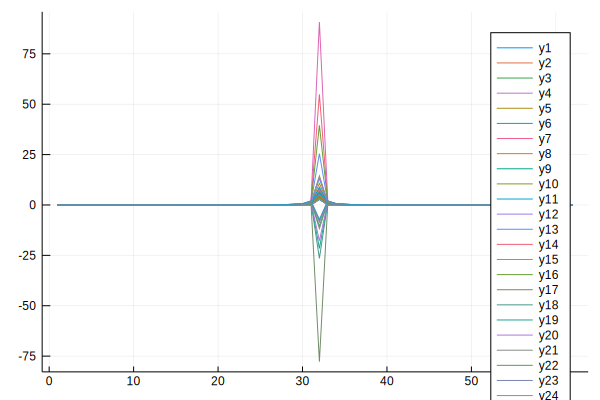

In [54]:
plot(real(χsp[20:(end-20),:]))

In [92]:
println(size(χch))
qiNorm = qMultiplicity/((2*(simParams.Nq-1))^2 * 8)
χ_qSum_lDGA = zeros(size(χch_lDGA))
for i in 1:size(χch_lDGA,1)
    χ_qSum_lDGA[i,:] .= (χch_lDGA[i,:] .+ χsp_lDGA[i,:]) .* qiNorm[:]
end
χ_qSum_lDGA = sum(χ_qSum_lDGA, dims=2)[:,1]
χ_q_lDGA = copy((χch_lDGA + χsp_lDGA));

(101, 55)


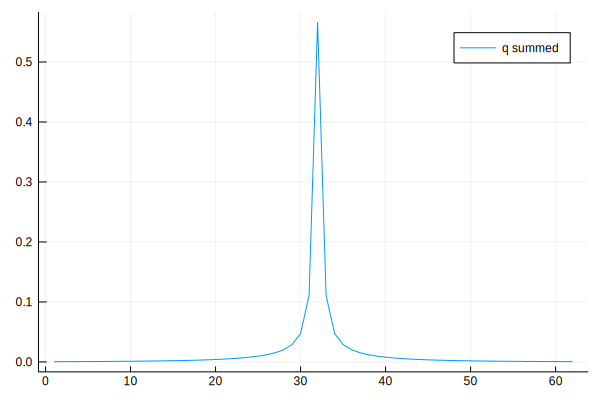

In [93]:
plot(real(χ_qSum_lDGA), label="q summed")
#plot!(real(arr_lDGA_q0), label="q0")

In [99]:
nc = [0,1,2,3,4]
ωmax_end   = floor(Int64,size(χ_q0_lDGA,1)/2)
start = ceil(Int64, (2/4)*ωmax_end)
W = build_weights(start, ωmax_end, nc)
sum_naive_q0_χ_lDGA = sum(χ_q_lDGA)/modelParams.β
sum_q0_χ_lDGA = sum([approx_full_sum(χ_q_lDGA[:,i] * qiNorm[i], W, modelParams, [1])/modelParams.β for i in 1:size(χ_q_lDGA, 2)])

sum_naive_χ_lDGA = sum(χ_qSum_lDGA)/modelParams.β
sum_χ_lDGA = approx_full_sum(χ_qSum_lDGA, W, modelParams, [1])/modelParams.β
println("q-summed after, fit: $(sum_q0_χ_lDGA)")
println("q-summed before: naive: $(sum_naive_χ_lDGA), fit: $(sum_χ_lDGA)")

q-summed after, fit: 0.044512548709707125
q-summed before: naive: 0.044671674281376805, fit: 0.044512548709703954


### Fit using Kinetic Energy from ED 

In [100]:
arr_lDGA_2 = copy(χ_qSum_lDGA)
println("Ekin = $(Ekin)")
iωₙ2_q0  = zeros(length(arr_lDGA_2))
for i in 1:length(arr_lDGA_2)
    iωₙ2_q0[i] = (iω(i - ceil(Int64, length(arr_lDGA_2)/2)))^2
end
ind_0 = argmax(iωₙ2_q0)
for n in 1:length(arr_lDGA_2)
    if n != ind_0
        arr_lDGA_2[n] += 2*Ekin/iωₙ2_q0[n]
    end
end
sum_imp_χ_lDGA = (sum(arr_lDGA_2) + rem_full)/(modelParams.β)

UndefVarError: UndefVarError: Ekin not defined

In [101]:
println(size(iωₙ2_q0))
println(size(χch_lDGA))
plot((real(χch_lDGA[:,1] .* iωₙ2_q0)), label="χEDch")
plot!((real(χsp_lDGA[:,2] .* iωₙ2_q0)), label="χEDsp")
plot!(repeat([2*Ekin], size(χsp,1)), label="Ekin")

(62,)
(62, 55)


UndefVarError: UndefVarError: Ekin not defined

In [102]:
plot(real(sum(arr_lDGA,dims=2))[10:(end-10)], label="q summed")
plot!(arr_ED[569:(end-569)], label="ED")
plot!(real(arr_lDGA_q0)[10:(end-10)], label="q0")

UndefVarError: UndefVarError: arr_ED not defined

In [104]:
arr_lDGA = χch_lDGA + χsp_lDGA
nc = [0,1,2,3,4]
νmax_end   = floor(Int64,size(arr_lDGA,1)/2)
start = ceil(Int64, (2/4)*νmax_end)
W = build_weights(start, νmax_end, nc)
tail_χch_ed = approx_full_sum(χ_qSum_lDGA, W, modelParams, [1])/modelParams.β

0.044512548709703954

In [105]:
println(sum(χEDch)/modelParams.β)
println(maximum(sum_χch_ed)+maximum(sum_χsp_ed))
println((tail_χch_ed + tail_χsp_ed)/2)
println((sum(χEDch) + sum(χEDsp))/(2*20.0))
plot(χEDch)

UndefVarError: UndefVarError: χEDch not defined

In [106]:
#println(total_sum_χch_ed[end]/2)
#println(total_tail_χch_ed[1]/2)
println(total_sum_χch_fit[end]/2)
println(total_tail_χch_fit[1]/2)
plot(2:length(total_sum_χch_ed)+1,total_sum_χch_ed, label="χED(ωmax)")
plot!(3:length(total_sum_χch_fit)+2,total_sum_χch_fit, label="χFit(ωmax)")

UndefVarError: UndefVarError: total_sum_χch_fit not defined

### Naive sums

In [409]:
checkED = round(sum(arrFit)/(2*modelParams.β); digits=4)
checkFit = round(sum(arrED)/(2*modelParams.β); digits=4)
checkNaive = round(sum(arrNaive)/(2*modelParams.β); digits=4)
println("checking for ω sum. Value should be close to 0.25: ED: $checkED, Fit: $checkFit, Naive: $checkNaive")

checking for ω sum. Value should be close to 0.25: ED: 0.2414, Fit: 0.2467, Naive: 0.1762


### Fitted sums

In [411]:
checkED = round(total_tail_χch_ed/2; digits=10)
checkFit = round(total_tail_χch_fit/(2); digits=10)
checkNaive = round(sum(arrNaive)/(2*modelParams.β); digits=10)
println("checking for ω sum. Value should be close to 0.25: ED: $checkED, Fit: $checkFit, Naive: $checkNaive")

checking for ω sum. Value should be close to 0.25: ED: 0.2499999952, Fit: 0.2529847828, Naive: 0.1762046065


# Test ω-Fit on exact ED input

# Test physical properties

We want $\frac{1}{2 \beta} \sum_{q,\omega} \left( \chi^\text{ch}(q, \omega)_\text{lDGA} + \chi^{\text{sp}, \lambda}_\text{lDGA}(q, \omega) \right) = n (n-1) = \frac{1}{4}$
From the first section we assume, that the nubmer of coefficients should be set to $5$ and $\nu maxstart$ should be in the last $20 \%$ of the tail.

We start by computing the $\nu, \nu'$ sum over $\chi^\text{sp}$ and $\chi^\text{ch}$.
The correct tail behaviour is checked by plotting both functions as a function of $\omega$.

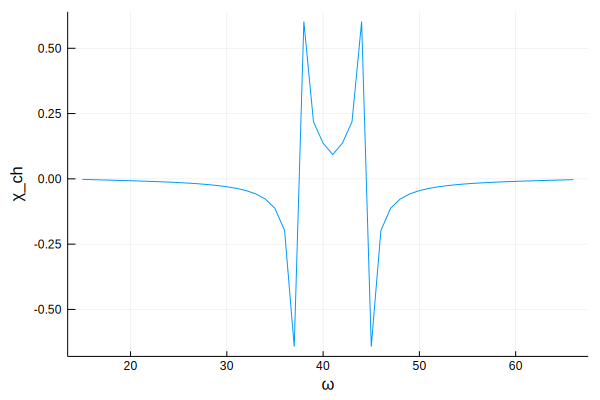

In [352]:
range = 15:(size(χch,1)-15)
plot(range, real.(χch[range,1]), xlabel="ω", ylabel="χ_ch", legend = false)

#for i = 2:(size(χch,2)-40)
#    plot!(range, real.(χch[range,i]))
#end

#plot!(range,real.(χch[range,end]))

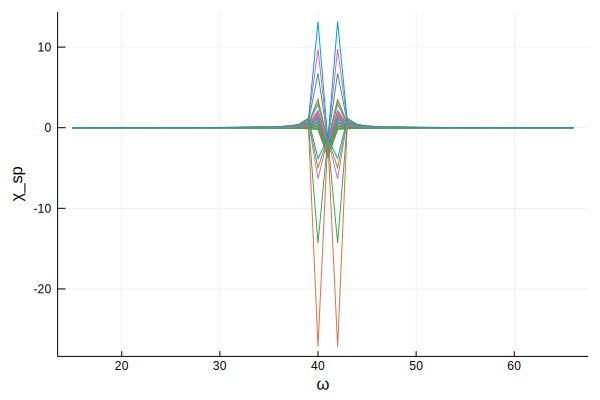

In [343]:
plot(range, real.(χsp[range,20]), xlabel="ω", ylabel="χ_sp", legend = false)

for i = 2:(size(χsp,2)-1)
    plot!(range, real.(χsp[range,i]))
end

plot!(range, real.(χsp[range,end]))

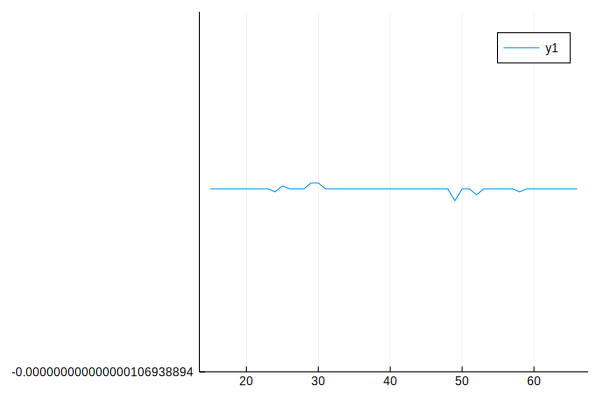

In [84]:
plot(range, real.(χch[range,1] - χch_λ[range,1]))

We now compute the $\omega$ sum. The $\omega$ sum has to be fitted again.

In [124]:

nc = 5
νmax_end   = floor(Int64,size(χch[range,:],1)/2)

start = floor(Int64, νmax_end*(3/4))
println("f(νmax) goes from $start to $νmax_end")
W = build_weights(start, νmax_end, nc)

sum_χch = build_fνmax(χch[range,:], W, modelParams, simParams, [1])
tail_χch = fit_νsum(W, sum_χch)
arr_rangech = find_usable_interval(tail_χch; reduce_range_prct = 0.1);


sum_χsp = build_fνmax(χsp_λ[range,:], W, modelParams, simParams, [1])
tail_χsp = fit_νsum(W, sum_χsp)
arr_rangesp = find_usable_interval(tail_χsp; reduce_range_prct = 0.1);

f(νmax) goes from 19 to 26


## Test best parameter range

In [109]:
using DelimitedFiles
chi_asymt = readdlm(env.inputDir * "/chi_asympt")
χEDch = (chi_asymt[:,2] + chi_asymt[:,4]) / (2*modelParams.β*modelParams.β);
χcharge = χup .+ χdo
χspin = χup .- χdo
χEDsp = (chi_asymt[:,2] - chi_asymt[:,4]) / (2*modelParams.β*modelParams.β);
χch_lDGA = sum(χch, dims=2);
χsp_lDGA = sum(χsp, dims=2);

In [3]:
function find_inner_maximum(arr)
    darr = diff(arr; dims=1)
    mid_index = Int(floor(size(arr,1)/2))
    intervall_range = 1
    
    # find interval
    while (intervall_range < mid_index) && 
        (darr[(mid_index-intervall_range)] * darr[(mid_index+intervall_range-1)] > 0)
            intervall_range = intervall_range+1
    end
    
    index_maximum = mid_index-intervall_range+1
    if (mid_index-intervall_range) < 1 || index_maximum >= length(arr)
        return 1
    end
    # find index
    while darr[(mid_index-intervall_range)]*darr[index_maximum] > 0
        index_maximum = index_maximum + 1
    end
    return index_maximum
end


function find_usable_interval(arr; reduce_range_prct = 0.1)
    darr = diff(arr; dims=1)
    index_maximum = find_inner_maximum(arr)
    mid_index = Int(floor(size(arr,1)/2))
    if (index_maximum == 1)
        println("no maximum found")
        return 1:1
    end
    # interval for condition 1 (positive values)
    #TODO: implement min-max
    cond1_intervall_range_min = 1
    cond1_intervall_range_max = 1
    # find range for positive values
    while (cond1_intervall_range < mid_index) &&
        (arr[(mid_index-cond1_intervall_range)] > 0) &&
        (arr[(mid_index+cond1_intervall_range)] > 0)
        cond1_intervall_range = cond1_intervall_range + 1
    end
    
    # interval for condition 2 (monotonicity)
    cond2_intervall_range_min = 1
    cond2_intervall_range_max = 1
    # find range for first turning point
    while (cond2_intervall_range < mid_index) &&
        (darr[(mid_index-cond2_intervall_range)] > 0) &&
        (darr[(mid_index+cond2_intervall_range)] < 0)
        cond2_intervall_range = cond2_intervall_range + 1
    end
    
    intervall_range = minimum([cond1_intervall_range, cond2_intervall_range])
    range = floor(Int64, intervall_range*(1-reduce_range_prct))
    return (((mid_index-range):(mid_index+range)) .+ 0)
end

find_usable_interval (generic function with 1 method)

In [4]:
@everywhere include("src/Config.jl")
@everywhere include("src/GFTools.jl")
@everywhere include("src/ladderDGATools.jl")
@everywhere include("src/helpers.jl")
@everywhere include("src/GFFit.jl")
@everywhere using Distributed
@everywhere using SharedArrays
@everywhere using LinearAlgebra
@everywhere using GenericLinearAlgebra


In [5]:
cutoff_range = 0:0
νmax_start_range = 1:58
n_coeff_range = 1:14

usable_ranges3 = SharedArray{Int64}(maximum(cutoff_range)+1, maximum(νmax_start_range), maximum(n_coeff_range))

@sync @distributed for cutoff in cutoff_range
    arr_ch = χcharge[(1+cutoff):(119-cutoff),:,:]
    νmax_end   = Int(size(arr_ch,3)/2)
    for νmax_start in νmax_start_range
        #if νmax_start < size(arr_ch,1)
        #    continue
        #end
        for n_coeff in n_coeff_range
            W = build_weights(νmax_start, νmax_end, n_coeff)
            sum_χch = build_fνmax(arr_ch, W, modelParams, simParams, [2,3])
            tail_χch = fit_νsum(W, sum_χch)
            arr_range = find_usable_interval(tail_χch; reduce_range_prct = 0.0)
            usable_ranges3[cutoff+1, νmax_start, n_coeff] = length(arr_range)
        end
    end
end
usable_ranges3 = sdata(usable_ranges3);

CompositeException: BoundsError: attempt to access 79×80×80 Array{Complex{Float64},3} at index [1:119, Base.Slice(Base.OneTo(80)), Base.Slice(Base.OneTo(80))]
throw_boundserror(::Array{Complex{Float64},3}, ::Tuple{UnitRange{Int64},Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}}}) at ./abstractarray.jl:538
checkbounds at ./abstractarray.jl:503 [inlined]
_getindex at ./multidimensional.jl:669 [inlined]
getindex(::Array{Complex{Float64},3}, ::UnitRange{Int64}, ::Function, ::Function) at ./abstractarray.jl:981
macro expansion at ./In[5]:8 [inlined]
(::getfield(Main, Symbol("##170#171")))(::UnitRange{Int64}, ::Int64, ::Int64) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/macros.jl:284
#168 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/macros.jl:43 [inlined]
run_work_thunk(::getfield(Distributed, Symbol("##168#170")){UnitRange{Int64},getfield(Main, Symbol("##170#171")),UnitRange{Int64}}, ::Bool) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/process_messages.jl:79
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/process_messages.jl:88 [inlined]
(::getfield(Distributed, Symbol("##102#104")){Distributed.RemoteValue,getfield(Distributed, Symbol("##168#170")){UnitRange{Int64},getfield(Main, Symbol("##170#171")),UnitRange{Int64}}})() at ./task.jl:268
wait_ref at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/remotecall.jl:487 [inlined]
call_on_owner at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/remotecall.jl:477 [inlined]
wait(::Future) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Distributed/src/remotecall.jl:500
sync_end(::Array{Any,1}) at ./task.jl:222
(::getfield(Distributed, Symbol("##167#169")){getfield(Main, Symbol("##170#171")),UnitRange{Int64}})() at ./task.jl:254

In [6]:
println(maximum(usable_ranges2))
println(findall(usable_ranges2 .>= (maximum(usable_ranges2)-8)))
usable_ranges2[findall(usable_ranges2 .>= (maximum(usable_ranges2)-8))]

UndefVarError: UndefVarError: usable_ranges2 not defined

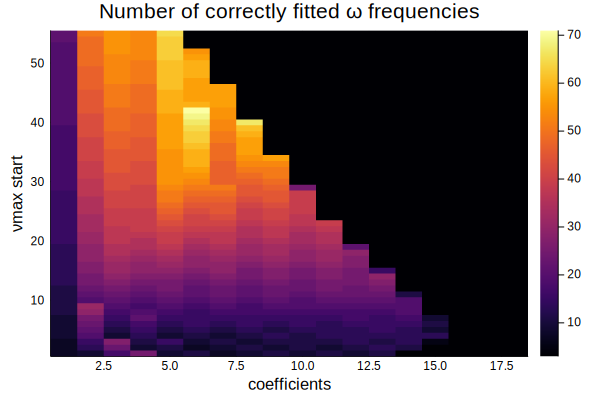

In [758]:
M = usable_ranges[1,:,:]
gr()
#p = Gadfly.spy(M)
p = ones(5,5)
p[end, end] = -1
heatmap(M, ylabel="νmax start", xlabel="coefficients",
    title="Number of correctly fitted ω frequencies")

In [738]:
save("usable_ranges.jld", "usable_ranges", usable_ranges, "usable_ranges2", usable_ranges2)

In [699]:
cutoff = 0
start = 42
nc = 6
arr_ch = χcharge[(1+cutoff):(119-cutoff),:,:]
νmax_end   = Int(size(arr_ch,3)/2)
W = build_weights(start, νmax_end, nc)
sum_χch = build_fνmax(arr_ch, W, modelParams, simParams, [2,3])
tail_χch = fit_νsum(W, sum_χch)
arr_range = find_usable_interval(tail_χch; reduce_range_prct = 0.0)

24:94

## Investigate largest range degeneracy of coefficients

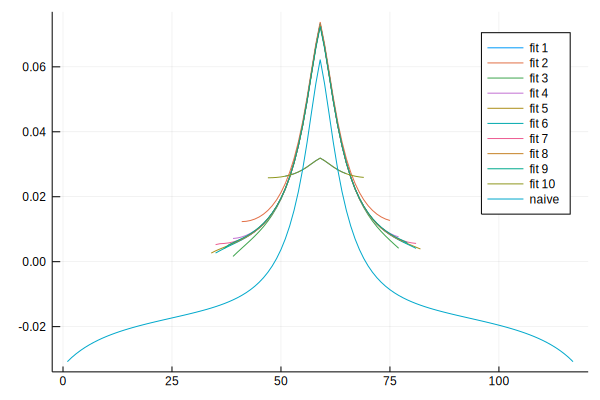

In [790]:
cutoff = 1
start = 29
nc = 1
arr_ch = χcharge[(1+cutoff):(119-cutoff),:,:]
νmax_end   = Int(size(arr_ch,3)/2)
W = build_weights(start, νmax_end, nc)
sum_χch0 = build_fνmax(arr_ch, W, modelParams, simParams, [2,3])
tail_χch0 = fit_νsum(W, sum_χch0)
arr_range0 = find_usable_interval(tail_χch0; reduce_range_prct = 0.05)

plot(arr_range0, tail_χch[arr_range0], label="fit 1")

for nc = 2:1:10
    W = build_weights(start, νmax_end, nc)
    sum_χch = build_fνmax(arr_ch, W, modelParams, simParams, [2,3])
    tail_χch = fit_νsum(W, sum_χch)
    arr_range = find_usable_interval(tail_χch; reduce_range_prct = 0.05)
    plot!(arr_range, tail_χch[arr_range], label="fit $nc")
end
plot!(1:117, real.(sum_χch0[:,end]), label="naive")

In [69]:
# Test basics for analytic LSQ

In [59]:
include("src/GFFit.jl")

approx_full_sum (generic function with 1 method)

In [95]:
include("src/GFFit.jl")
arr_ch = χcharge[:,:,:]
arr_sp = χspin[:,:,:]
νmax_end   = Int(size(arr_ch,3)/2)
νmax_start = Int(size(arr_ch,3)/4)
W = build_weights(νmax_start, νmax_end, [0,1,2,3,4])
sum_χch = build_fνmax(arr_ch, W, modelParams, simParams, [2,3])
tail_χch_int = fit_νsum(W, sum_χch)
tail_χsp = approx_full_sum(arr_sp, W, modelParams, simParams, [2,3])/(modelParams.β^2);
tail_χch = approx_full_sum(arr_ch, W, modelParams, simParams, [2,3])/(modelParams.β^2);

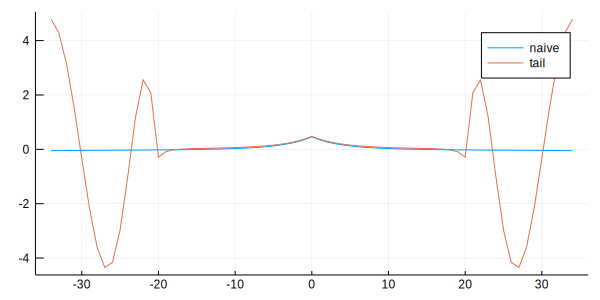

In [97]:
tail_χch2 = tail_χch_int[6:(end-5),:];
sum_χch2 = sum_χch[6:(end-5),:];
x_arr = -(Int(floor(size(tail_χch2,1)/2))):(Int(floor(size(tail_χch2,1)/2)))
plot(x_arr,real(sum_χch2[:,end]), label="naive", size=(600, 300))
#plot!(0:Int(floor(size(tail_χch2,1)))-1,χEDch[1:Int(floor(size(tail_χch2,1)))], label="ED")
plot!(x_arr, real(tail_χch2[:]), label="tail")

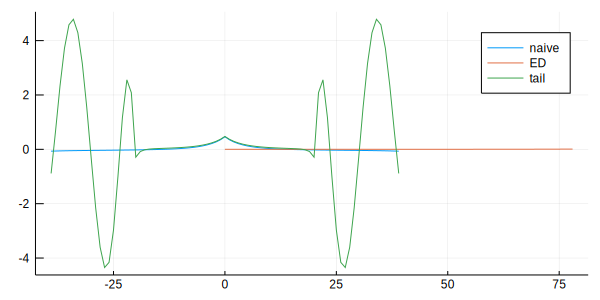

In [98]:
x_arr = -(Int(floor(size(tail_χch,1)/2))):(Int(floor(size(tail_χch,1)/2)))
plot(x_arr,real(sum_χch[:,end]), label="naive", size=(600, 300))
plot!(0:Int(floor(size(tail_χch,1)))-1,χEDch[1:Int(floor(size(tail_χch,1)))], label="ED")
plot!(x_arr, real(tail_χch[:]), label="tail")

In [99]:
x_arr = (-Int(floor(size(tail_χsp,1)/2))):(Int(floor(size(tail_χsp,1)/2)))
plot(x_arr,real(sum_χsp[:,end]), label="naive", size=(1200, 800))
plot!(0:Int(floor(size(tail_χsp,1)))-1,χEDsp[1:Int(floor(size(tail_χch,1)))], label="ED")
plot!(x_arr, real(tail_χsp), label="tail")

MethodError: MethodError: no method matching lastindex(::Float64, ::Int64)
Closest candidates are:
  lastindex(!Matched::HDF5.HDF5Dataset, ::Int64) at /home/julian/.julia/packages/HDF5/Zh9on/src/HDF5.jl:1137
  lastindex(::Number) at number.jl:71
  lastindex(!Matched::AbstractArray, ::Any) at abstractarray.jl:304

Next we compute the $\omega$ and $q$ sum over both values

In [125]:
sum(tail_χch + tail_χsp)/(2)

1.4073413230608303

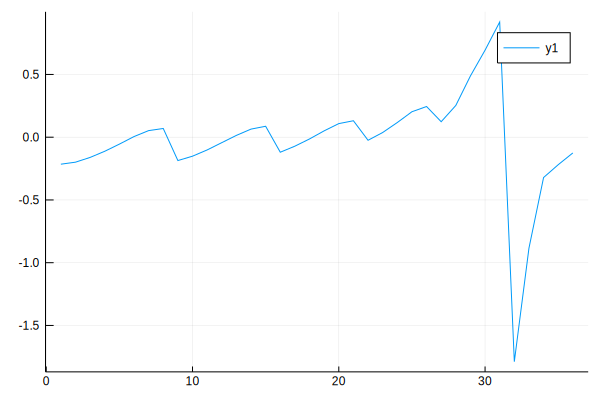

In [92]:
plot(tail_χsp)

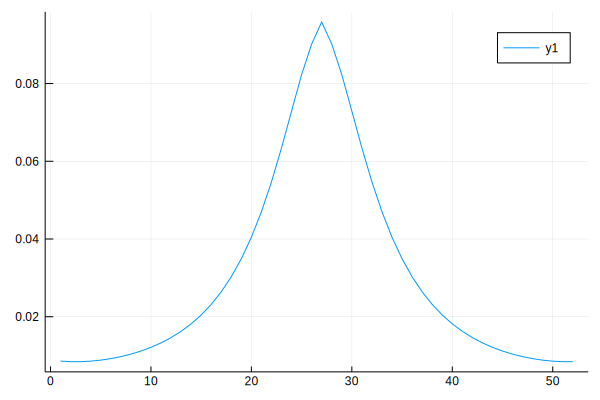

In [73]:
plot(real.(χch[range,33]))